# Gerekli fonksiyon tanımlamalarını yaptım.

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)

# Veri setini okumak için gerkeli olan fonksiyon.

In [21]:

def load_data(file_path):
    return pd.read_excel(file_path)


# Veri setine göz gezdirdim. 

In [22]:
def check_df(dataframe, count=3):
    print("########################################## Head ##########################################")
    print(dataframe.head(count))
    print("########################################## Tail ##########################################")
    print(dataframe.tail(count))
    print("########################################## Shape ##########################################")
    print(dataframe.shape)
    print("########################################## Types ##########################################")
    print(dataframe.dtypes)
    print("######################################### Unique #########################################")
    print(dataframe.nunique())
    print("######################################### Missing ##########################################")
    print(dataframe.isnull().sum())
    print("########################################## Quantiles ##########################################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

# Kolonların veri tiplerine ve değişkenlerine göre kolonları sınıflandırdım.

In [23]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, num_cols, cat_but_car


# Kategorik kolonların görselleştirmesini sağlayan fonksiyon.

In [24]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

# Sayısal değikenlerin arasındaki ilişkiyi gösteren korelasyon matrisini görselleştirdim.

In [25]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)


# Aynı kolon içinde bulunan 2 farklı veriyi yeni kolonlara ayrıştırdım.

In [26]:
def diseases(dataframe):
    diseases=["Kronik Hastaliklarim","Baba Kronik Hastaliklari","Anne Kronik Hastaliklari","Kiz Kardes Kronik Hastaliklari","Erkek Kardes Kronik Hastaliklari"]
    for disease in diseases:
        dataframe[[disease,disease+" 2"]] = dataframe[disease].str.split(',', expand=True)
    return dataframe

# Veri setindeki eksik kolonları görselleştirdim.

In [27]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    msno.bar(dataframe)
    plt.show()
    if na_name:
        return na_columns,plt.show()


# IQR yöntemi ile alt ve üst limitleri belirledim.

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


# IQR yönteminde alt ve üst limitlere göre aykırı değer var mı onu kontrol ettim.

In [29]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

# Önce eksik olsan cinsiyet değerlerini en çok tekrar eden veriye göre doldurdum. Daha sonra Yaş, boy ve kilo  değişkenlerinin cinsiyet kırılımlarına göre eksik verileri doldurdum. 
# İlacı aldığı yaş, vücut kitle indeksi, ilaç kullanım süresi, yan etki çıkma süresi gibi yeni değişkenler tanımladım.
# Vücut kitle indeksi değişkenini kendi içinde 4 parça bölerek kategorikleştirdim.
# Yaş değişkenini cinsiyet değişkeni ile birleştirerek yeni sınıflandırılmış bir kolon ekledim.

In [30]:
def fill_and_new_feature (dataframe):
    
    dataframe = dataframe.apply(lambda col: col.fillna(col.mode()[0]) if col.dtype == 'object' else col)
    
    dataframe["İlacı_Aldıgı_Yas"]=np.round((dataframe["Ilac_Baslangic_Tarihi"]-dataframe["Dogum_Tarihi"])/ np.timedelta64(1, "Y"))
    
    dataframe.loc[(dataframe["İlacı_Aldıgı_Yas"].isnull()) & (dataframe["Cinsiyet"]=="Female"), "İlacı_Aldıgı_Yas"] = dataframe.groupby("Cinsiyet")["İlacı_Aldıgı_Yas"].mean()["Female"]
    dataframe.loc[(dataframe["İlacı_Aldıgı_Yas"].isnull()) & (dataframe["Cinsiyet"]=="Male"), "İlacı_Aldıgı_Yas"] = dataframe.groupby("Cinsiyet")["İlacı_Aldıgı_Yas"].mean()["Male"]
    
    
    
    dataframe.loc[(dataframe["Boy"].isnull()) & (dataframe["Cinsiyet"]=="Female"), "Boy"] = dataframe.groupby("Cinsiyet")["Boy"].mean()["Female"]
    dataframe.loc[(dataframe["Boy"].isnull()) & (dataframe["Cinsiyet"]=="Male"), "Boy"] = dataframe.groupby("Cinsiyet")["Boy"].mean()["Male"]
    
    dataframe.loc[(dataframe["Kilo"].isnull()) & (dataframe["Cinsiyet"]=="Male"), "Kilo"] = dataframe.groupby("Cinsiyet")["Kilo"].mean()["Male"]
    dataframe.loc[(dataframe["Kilo"].isnull()) & (dataframe["Cinsiyet"]=="Female"), "Kilo"] = dataframe.groupby("Cinsiyet")["Kilo"].mean()["Female"]
    
    dataframe["Vucut_Kitle_Indeksi"]=dataframe["Kilo"]/(dataframe["Boy"]/100)**2
    dataframe["Yeni_Vucut_Kitle_Indeksi"] = pd.cut(x=dataframe["Vucut_Kitle_Indeksi"], bins=[-1, 18.5, 24.9, 29.9, 100],
                                 labels=["zayif", "saglikli", "asiri_kilolu", "obez"])
    
    dataframe["Ilac_Kullanım_Suresi_Gun"]=(dataframe["Ilac_Bitis_Tarihi"]-dataframe["Ilac_Baslangic_Tarihi"])/ np.timedelta64(1, "D")
    
    dataframe["Yan_Etki_Cıkma_Suresi_Gun"]=np.round((dataframe["Yan_Etki_Bildirim_Tarihi"]-dataframe["Ilac_Baslangic_Tarihi"])/ np.timedelta64(1, "D"))
    
    dataframe.loc[(dataframe['Cinsiyet'] == 'Male') & (dataframe['İlacı_Aldıgı_Yas'] <= 21), 'Yeni_Cinsiyet_Kategorisi'] = 'youngmale'
    dataframe.loc[(dataframe['Cinsiyet'] == 'Male') & (dataframe['İlacı_Aldıgı_Yas'] > 21) & (dataframe['İlacı_Aldıgı_Yas'] < 50), 'Yeni_Cinsiyet_Kategorisi'] = 'maturemale'
    dataframe.loc[(dataframe['Cinsiyet'] == 'Male') & (dataframe['İlacı_Aldıgı_Yas'] >= 50), 'Yeni_Cinsiyet_Kategorisi'] = 'seniormale'
    dataframe.loc[(dataframe['Cinsiyet'] == 'Female') & (dataframe['İlacı_Aldıgı_Yas'] <= 21), 'Yeni_Cinsiyet_Kategorisi'] = 'youngfemale'
    dataframe.loc[(dataframe['Cinsiyet'] == 'Female') & (dataframe['İlacı_Aldıgı_Yas'] > 21) & (dataframe['İlacı_Aldıgı_Yas'] < 50), 'Yeni_Cinsiyet_Kategorisi'] = 'maturefemale'
    dataframe.loc[(dataframe['Cinsiyet'] == 'Female') & (dataframe['İlacı_Aldıgı_Yas'] >= 50), 'Yeni_Cinsiyet_Kategorisi'] = 'seniorfemale'
    return dataframe


# Gereksiz kolonları sildim.

In [31]:
def drop_columns(dataframe,columns):
    dataframe.drop(columns=columns, inplace=True)
    return dataframe

# Sayısal değişkenleri görselleştirdim.

In [32]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


# Yeni eklediğim sayılsal değişkenlerinde içinde olduğu korelasyon matrisini oluşturudum.

In [33]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)


# Kategorik değişkenleri encode etmek için kullandığım fonksiyonlar.

In [34]:

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


In [35]:
def one_hot_encoder(dataframe, categorical_cols, categorical_cols2, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols2, drop_first=drop_first)
    return dataframe

# Boru hattı seviyesinde kullandığım fonksiyon.

########################################## Head ##########################################
   Kullanici_id Cinsiyet Dogum_Tarihi    Uyruk         Il          Ilac_Adi Ilac_Baslangic_Tarihi  \
0           107     Male   1960-03-01  Turkiye  Canakkale   trifluoperazine            2022-01-09   
1           140     Male   1939-10-12  Turkiye    Trabzon  fluphenazine hcl            2022-01-09   
2             2   Female   1976-12-17  Turkiye  Canakkale   warfarin sodium            2022-01-11   

  Ilac_Bitis_Tarihi   Yan_Etki Yan_Etki_Bildirim_Tarihi Alerjilerim  \
0        2022-03-04   Kabizlik      2022-02-19 18:28:43       Ceviz   
1        2022-03-08  Yorgunluk      2022-02-03 20:48:17         Toz   
2        2022-03-12   Carpinti      2022-02-04 05:29:20         Muz   

              Kronik Hastaliklarim Baba Kronik Hastaliklari          Anne Kronik Hastaliklari  \
0  Hipertansiyon, Kan Hastaliklari     Guatr, Hipertansiyon                              KOAH   
1                        

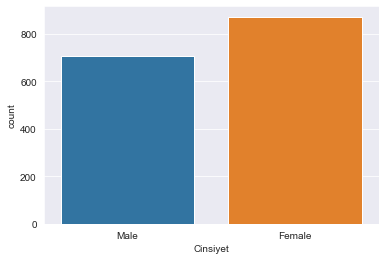

         Uyruk  Ratio
Turkiye   2357  100.0
##########################################


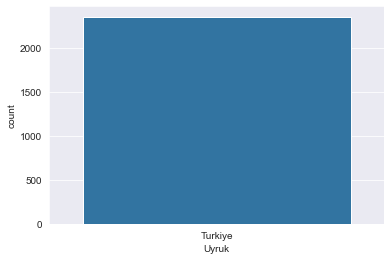

            Il     Ratio
Adana      220  9.333899
Mersin     207  8.782350
Trabzon    195  8.273229
Canakkale  179  7.594400
Ankara     179  7.594400
Eskisehir  174  7.382266
Antalya    171  7.254985
Bursa      169  7.170132
Samsun     153  6.491303
Istanbul   144  6.109461
Izmir      121  5.133644
Malatya    109  4.624523
Kayseri    109  4.624523
##########################################


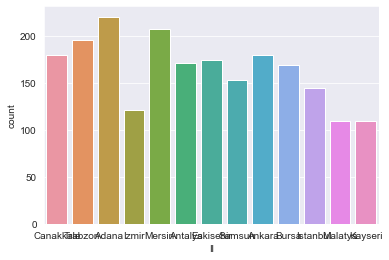

        Kan Grubu      Ratio
AB RH-        421  17.861689
0 RH+         275  11.667374
B RH+         256  10.861264
AB RH+        250  10.606703
B RH-         233   9.885448
0 RH-         232   9.843021
A RH+         198   8.400509
A RH-         145   6.151888
##########################################


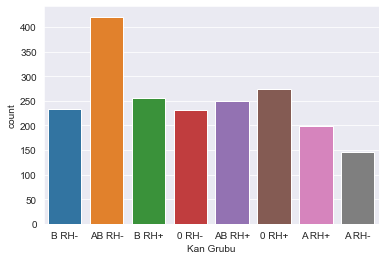

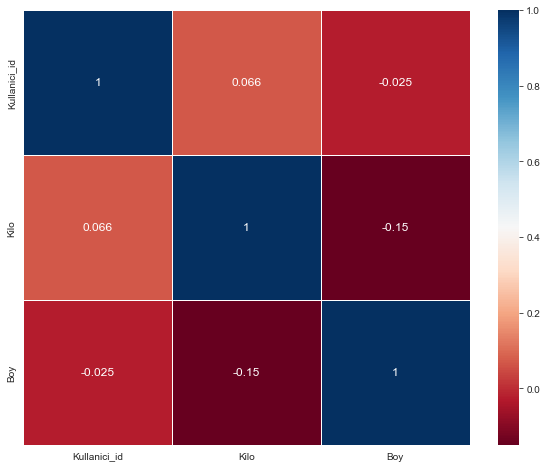

                                    n_miss  ratio
Cinsiyet                               778  33.01
Kiz Kardes Kronik Hastaliklari 2       662  28.09
Anne Kronik Hastaliklari 2             640  27.15
Erkek Kardes Kronik Hastaliklari 2     616  26.13
Baba Kronik Hastaliklari 2             592  25.12
Kronik Hastaliklarim 2                 578  24.52
Alerjilerim                            484  20.53
Kronik Hastaliklarim                   392  16.63
Kan Grubu                              347  14.72
Kilo                                   293  12.43
Il                                     227   9.63
Anne Kronik Hastaliklari               217   9.21
Baba Kronik Hastaliklari               156   6.62
Erkek Kardes Kronik Hastaliklari       121   5.13
Boy                                    114   4.84
Kiz Kardes Kronik Hastaliklari          97   4.12


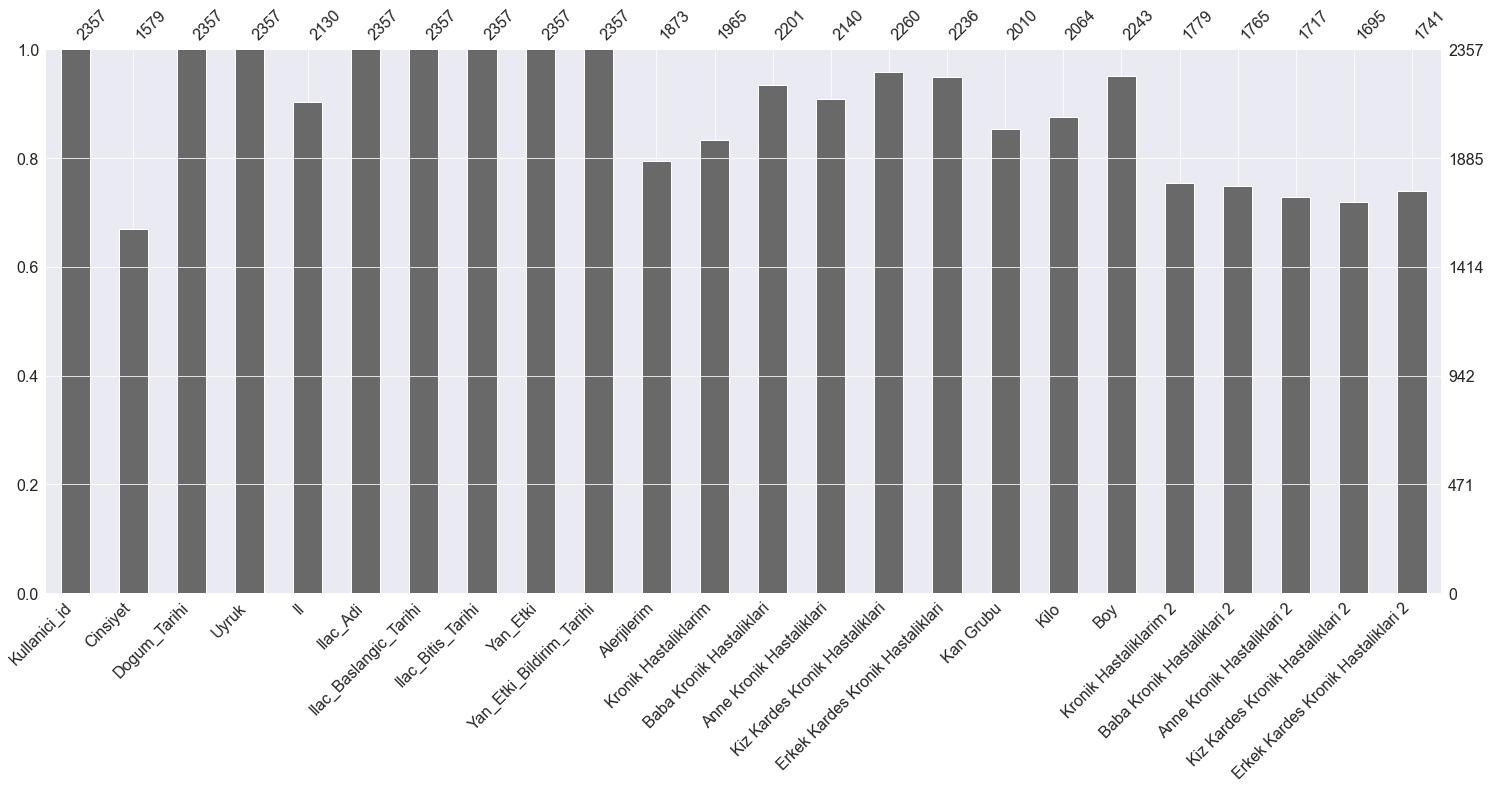

Kullanici_id False
Dogum_Tarihi False
Ilac_Baslangic_Tarihi False
Ilac_Bitis_Tarihi False
Yan_Etki_Bildirim_Tarihi False
Kilo False
Boy False
count    2357.000000
mean       80.818008
std        17.447163
min        50.000000
5%         52.000000
25%        67.000000
50%        81.000000
75%        94.000000
95%       108.000000
max       110.000000
Name: Kilo, dtype: float64


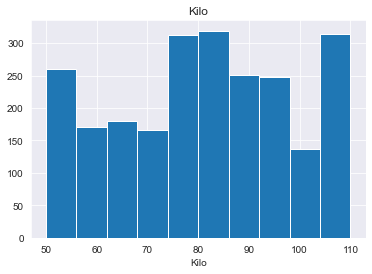

count    2357.000000
mean      174.647901
std        16.113445
min       145.000000
5%        147.000000
25%       160.000000
50%       176.000000
75%       187.000000
95%       201.000000
max       203.000000
Name: Boy, dtype: float64


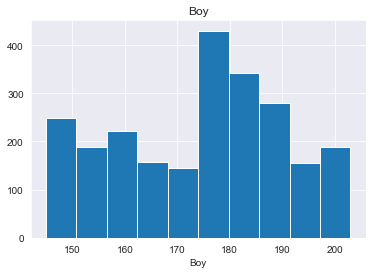

count    2357.000000
mean       47.115825
std        20.118678
min        11.000000
5%         15.000000
25%        30.000000
50%        48.000000
75%        63.000000
95%        80.000000
max        82.000000
Name: İlacı_Aldıgı_Yas, dtype: float64


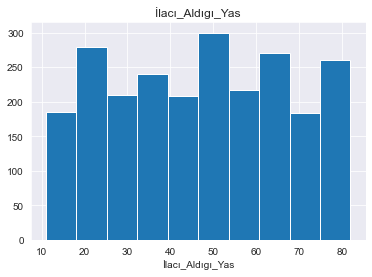

count    2357.000000
mean       27.335467
std         8.377492
min        12.623450
5%         15.396691
25%        20.953968
50%        26.583176
75%        32.393910
95%        43.281807
max        49.979175
Name: Vucut_Kitle_Indeksi, dtype: float64


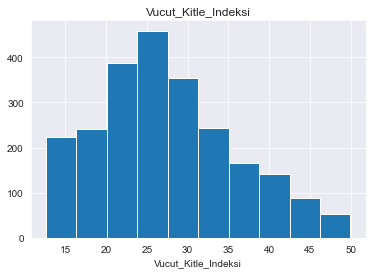

count    2357.000000
mean       62.234620
std         6.576611
min        47.000000
5%         51.000000
25%        58.000000
50%        62.000000
75%        67.000000
95%        73.000000
max        77.000000
Name: Ilac_Kullanım_Suresi_Gun, dtype: float64


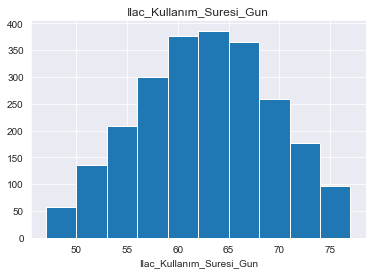

count    2357.000000
mean       34.212558
std         7.406248
min        18.000000
5%         22.000000
25%        29.000000
50%        34.000000
75%        40.000000
95%        47.000000
max        50.000000
Name: Yan_Etki_Cıkma_Suresi_Gun, dtype: float64


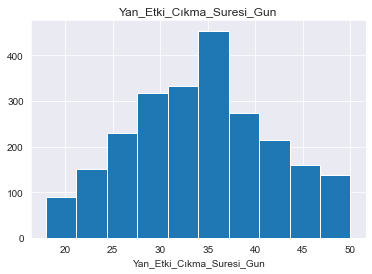

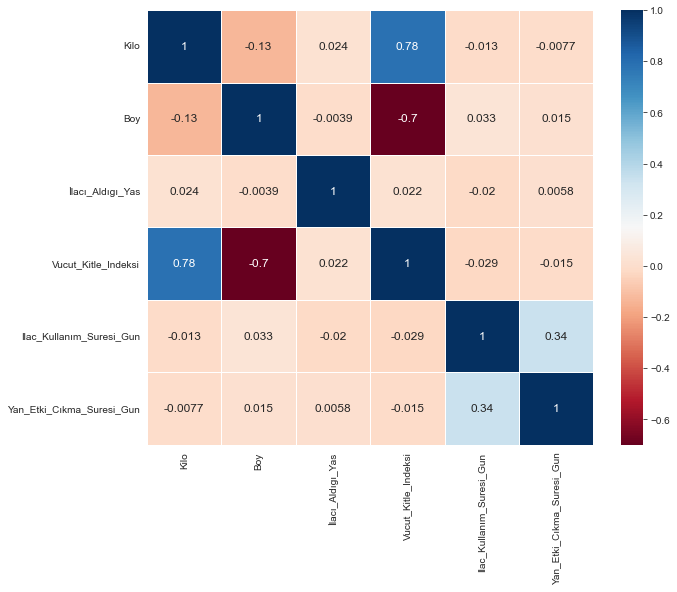

(          Kilo       Boy  İlacı_Aldıgı_Yas  Vucut_Kitle_Indeksi  Ilac_Kullanım_Suresi_Gun  \
 0     1.271651  1.015026          0.739976             0.107264                 -1.252373   
 1     0.010433  0.394295          1.734288            -0.311728                 -0.644028   
 2     0.698370 -1.033388         -0.105190             1.184159                 -0.339855   
 3     0.152596 -0.598876         -0.105190             0.397275                  0.724749   
 4     1.042339 -0.164364         -0.105190             0.731707                 -1.556545   
 ...        ...       ...               ...                  ...                       ...   
 2352 -1.766737 -1.405826          0.889123            -0.679846                 -1.860718   
 2353 -0.065385  0.208075         -1.497226            -0.261223                 -0.035683   
 2354  0.526386  1.759904          1.137701            -0.656132                  1.028921   
 2355  0.526386  0.580514         -0.254336            -0.08

In [36]:
def pipeline (file_path):
    # Veriyi okudum.
    dataframe = load_data(file_path)
    # Veriye göz gezdirdim.
    check_df(dataframe)
    # Kolonların veri tipine göre ayrıştırma yaptım.
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)
    
    # Kategorik verilerin görselleştirmesini yaptım.
    for col in cat_cols:
        cat_summary(dataframe, col,True)
        
    # Korelasyon matrisini görselleştirim.
    correlation_matrix(dataframe, num_cols)
    
    # 2 tane hastalık olarak tutulan kolonları ayrıştırıp ekstra kolonlar ekledim.
    diseases(dataframe)
    
    # Eksik verilerin oranlarını görselleştirim.
    missing_values_table(dataframe, False)
    
    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)
    
    # Aykırı değer var mı ? onu kontrol ettim.
    for col in num_cols:
        print(col, check_outlier(dataframe, col))
    
    # Eksik verileri doldurdum. Yeni özellikler ürettim.
    df=fill_and_new_feature(dataframe)
    
    # Gereksiz kolonları sildim.
    drop_columns(df,columns=["Kullanici_id","Uyruk","Dogum_Tarihi","Yan_Etki_Bildirim_Tarihi","Ilac_Baslangic_Tarihi","Ilac_Bitis_Tarihi"])
    
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
    
    # Yeni veri setindeki sayısal kolonların görselleştirmesini yaptım.
    for col in num_cols:
        num_summary(df, col, plot=True)
    
    # Yeni veri setindeki korelasyon matrisini görselleştirdim.
    correlation_matrix(df, num_cols)
    
    # Hedef kolonu farklı bir değişkene atayıp ana veri setinden sildim.
    y = df["Yan_Etki"]
    df= df.drop(["Yan_Etki"], axis=1)
    
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
    
    # iki değişkene sahip kategorik kolonları encode ettim. 
    binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
                   and df[col].nunique() == 2]
    
    for col in binary_cols:
        label_encoder(df, col)
    
    # KAtegorik kolonlara encode ettim.
    df = one_hot_encoder(df, cat_cols,cat_but_car, drop_first=True)
    
    # Verileri Standart Scaler yöntemi ile scale ettim.
    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)
    
    X=df
    # Sınıflandırma yöntemi için makine öğrenmesi algoritmaları için hazır hale getirdim.
    return X,y

pipeline("side_effect_data 1.xlsx")